In [11]:
# %matplotlib agg
%run utils.ipynb

In [12]:
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns

import kinesis as kn
import gapipes as gp

# This does not work with 'inline' backend: it will output latex
# compile error although PDF outputs etc will be saved correctly.
# I do not know why.
mystyledict.update({"text.usetex": True, "axes.unicode_minus": True})
plt.style.use(mystyledict)

In [13]:
def savefig(fig, basename, **kwargs):
    fig.savefig("../report/plots/plot-comparisons/{}.pdf".format(basename), **kwargs)

In [14]:
out_full = pd.read_csv("../data/hyades_full.csv")
df = out_full.loc[out_full["in_dr2"] == True].copy()
b0 = np.median(df.g.icrs.cartesian.xyz.value, axis=1)
with np.printoptions(formatter=dict(float=lambda x: "{:7.3f}".format(x))):
    print(f"b0 = {b0} pc")


def add_cartesian_xv(df):
    df["x"], df["y"], df["z"] = df.g.icrs.cartesian.xyz.value
    df["vx"], df["vy"], df["vz"] = df.g.icrs.velocity.d_xyz.value
    df["gx"], df["gy"], df["gz"] = df.g.galactic.cartesian.xyz.value
    df["gvx"], df["gvy"], df["gvz"] = df.g.galactic.velocity.d_xyz.value


add_cartesian_xv(out_full)
add_cartesian_xv(df)

fit_dict = {
#     "dr2": kn.load_stanfit("../report/hyades-dr2/fit.pickle"),
    "dr2": kn.load_stanfit("../report/hyades-dr2/fit_brightcorr.pickle"),
    "all": kn.load_stanfit("../report/hyades-dr2/fit_allstars.pickle"),
    "harpsRV": kn.load_stanfit("../report/hyades-dr2/fit_harpsrv.pickle"),
    "harpsRVall": kn.load_stanfit("../report/hyades-dr2/fit_allstars_harpsrv.pickle"),
}
azfit_dict = {
    k: add_transformed_posterior(az.from_pystan(v)) for k, v in fit_dict.items()
}

b0 = [ 17.268  41.643  13.606] pc


In [82]:
# generate a summary table of all parameters
pars = [
    "f_mem",
    "v0",
    "Sigma_gal",
    "omegax_gal",
    "omegay_gal",
    "omegaz_gal",
    "w1_gal",
    "w2_gal",
    "w3_gal",
    "w4_gal",
    "w5_gal",
    "kappa_gal",
]
# t1 = az.summary(azfit_dict["harpsRV"], pars)
# t2 = az.summary(azfit_dict["harpsRVall"], pars)
t1 = az.summary(azfit_dict["dr2"], pars)
t2 = az.summary(azfit_dict["all"], pars)



def cleantable(t):
    return t[["mean", "sd", "hpd_3%", "hpd_97%"]].drop(
        index=["Sigma_gal[1,0]", "Sigma_gal[2,0]", "Sigma_gal[2,1]"],
    )


t1, t2 = list(map(cleantable, [t1, t2]))
merged_table = pd.concat([t1, t2], axis=1).rename(
    index={
        "f_mem": r"\fmem",
        "v0[0]": "$v_{0,x}$ (ICRS)",
        "v0[1]": "$v_{0,y}$ (ICRS)",
        "v0[2]": "$v_{0,z}$ (ICRS)",
        "Sigma_gal[0,0]": "$\Sigma_{xx}$",
        "Sigma_gal[0,1]": "$\Sigma_{xy}$",
        "Sigma_gal[0,2]": "$\Sigma_{xz}$",
        "Sigma_gal[1,1]": "$\Sigma_{yy}$",
        "Sigma_gal[1,2]": "$\Sigma_{yz}$",
        "Sigma_gal[2,2]": "$\Sigma_{zz}$",
        "w1_gal": "$w_1$",
        "w2_gal": "$w_2$",
        "w3_gal": "$w_3$",
        "w4_gal": "$w_4$",
        "w5_gal": "$w_5$",
        "kappa": "$\kappa$",
        'omegax_gal':'$\omega_x$',
        'omegay_gal':'$\omega_y$',
        'omegaz_gal':'$\omega_z$',
        'kappa_gal':'$\kappa$'
    },
    columns={
        'hpd_3%':'hpd 3\%','hpd_97%':'hpd 97\%'
    }
).T
print(merged_table.iloc[:,:].T.to_csv())

,mean,sd,hpd 3\%,hpd 97\%,mean,sd,hpd 3\%,hpd 97\%
\fmem,0.995,0.003,0.99,1.0,0.85,0.011,0.83,0.87
"$v_{0,x}$ (ICRS)",-6.071,0.027,-6.121,-6.02,-6.009,0.029,-6.063,-5.954
"$v_{0,y}$ (ICRS)",45.685,0.052,45.588,45.782,45.673,0.06,45.557,45.783
"$v_{0,z}$ (ICRS)",5.546,0.023,5.502,5.59,5.557,0.025,5.512,5.606
$\Sigma_{xx}$,0.283,0.065,0.161,0.4,1.148,0.107,0.96,1.352
$\Sigma_{xy}$,0.017,0.052,-0.079,0.114,0.46,0.055,0.358,0.561
$\Sigma_{xz}$,0.08,0.045,-0.003,0.168,0.217,0.028,0.166,0.27
$\Sigma_{yy}$,0.144,0.01,0.126,0.163,0.459,0.035,0.395,0.527
$\Sigma_{yz}$,-0.006,0.021,-0.045,0.034,0.075,0.014,0.048,0.102
$\Sigma_{zz}$,0.189,0.037,0.116,0.257,0.234,0.016,0.206,0.264
$\omega_x$,1.882,3.917,-5.517,9.18,-1.08,1.401,-3.69,1.491
$\omega_y$,-1.571,8.23,-16.012,14.928,6.864,2.464,2.493,11.702
$\omega_z$,-3.793,5.561,-14.273,6.744,-2.262,0.624,-3.429,-1.082
$w_1$,-0.487,3.846,-7.865,6.389,1.028,1.414,-1.567,3.673
$w_2$,-2.829,8.674,-19.45,13.146,8.275,2.502,3.932,13.238
$w_3$,-1.432,5.388,-

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


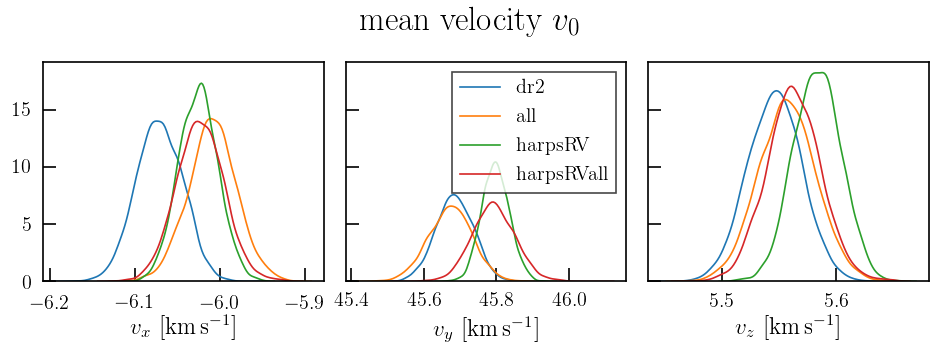

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), sharey=True)

for i, cax in enumerate(ax):
    for k, v in azfit_dict.items():
        sns.kdeplot(
            v.posterior["v0"].stack(samples=["chain", "draw"])[i],
            ax=cax,
            legend=False,
            label=k,
        )
ax[0].set_xlabel("$v_x$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1].set_xlabel("$v_y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[2].set_xlabel("$v_z$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
fig.suptitle("mean velocity $v_0$", size=20)
ax[1].legend()
fig.tight_layout(rect=[0, 0, 1, 0.9])
# savefig(fig, "mean_velocity")

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


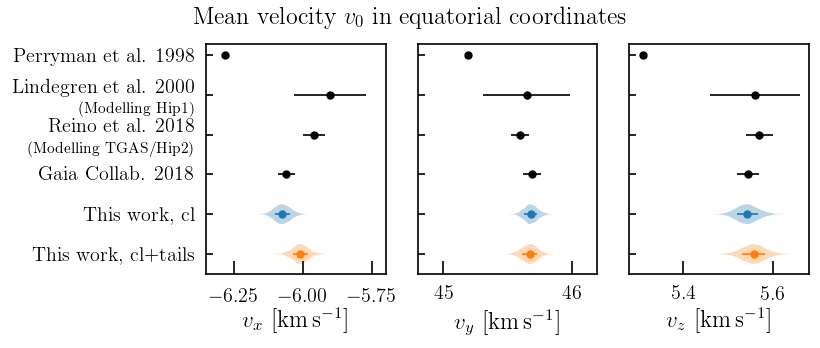

In [5]:
from io import StringIO

prev = pd.read_csv(
    StringIO(
        """
# Compile only the most relevant
label,vx,vx_sig,vy,vy_sig,vz,vz_sig
"Gaia HR",-6.059, 0.031, 45.691,0.069,5.544,0.025
"Reino et al. 2018\nModelling TGAS/Hipparcos-2",-5.96,0.04,45.60,0.07,5.57, 0.03 
"Lindegren et al. 2000\nModelling Hipparcos-1",-5.90,0.13,45.65,0.34,5.56, 0.10 
"Perryman et al. 1998",-6.28,0,45.19,0,5.31,0
"""
    ),
    skipinitialspace=True,
    comment="#",
)

v0df = pd.DataFrame(
    azfit_dict["dr2"].posterior["v0"].stack(i=["chain", "draw"]).values.T,
    columns=["vx", "vy", "vz"],
)
v0df_all = pd.DataFrame(
    azfit_dict["all"].posterior["v0"].stack(i=["chain", "draw"]).values.T,
    columns=["vx", "vy", "vz"],
)

fig, ax = plt.subplots(1, 3, figsize=(7, 3), sharey=True)
fig.suptitle("Mean velocity $v_0$ in equatorial coordinates", y=0.96)
for cax, label in zip(ax, ["vx", "vy", "vz"]):
    # cl
    cax.violinplot(v0df[label], vert=False, positions=[-1,], showextrema=False)
    cax.errorbar(
        np.median(v0df[label]),
        -1,
        xerr=[
            [np.median(v0df[label]) - np.percentile(v0df[label], 16)],
            [np.percentile(v0df[label], 84) - np.median(v0df[label])],
        ],
        marker="o",
        c="C0",
        ms=4,
    )
    # cl+tails
    cax.violinplot(v0df_all[label], vert=False, positions=[-2,], showextrema=False)
    cax.errorbar(
        np.median(v0df_all[label]),
        -2,
        xerr=[
            [np.median(v0df_all[label]) - np.percentile(v0df_all[label], 16)],
            [np.percentile(v0df_all[label], 84) - np.median(v0df_all[label])],
        ],
        marker="o",
        c="C1",
        ms=4,
    )

    cax.errorbar(
        prev[label],
        np.arange(len(prev)),
        xerr=prev["{}_sig".format(label)],
        ls="",
        marker="o",
        c="k",
        ms=4,
    )
ax[0].set_yticks([-2, -1, 0, 1, 2, 3])
ax[0].set_yticklabels(
    [
        "This work, cl+tails",
        "This work, cl",
        "Gaia Collab. 2018",
        "Reino et al. 2018\n{\small (Modelling TGAS/Hip2)}",
        "Lindegren et al. 2000\n{\small (Modelling Hip1)}",
        "Perryman et al. 1998",
    ]
)
ax[0].set_xlim([-6.35, -5.7])
ax[1].set_xlim([44.8, 46.2])
ax[2].set_xlim([5.28, 5.68])
for cax in ax[:]:
    cax.tick_params("y", which="major", length=4)
ax[0].set_xlabel("$v_x$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1].set_xlabel("$v_y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[2].set_xlabel("$v_z$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
fig.tight_layout(rect=[0, 0, 1, 0.93])
savefig(fig, "mean_velocity_comparison")

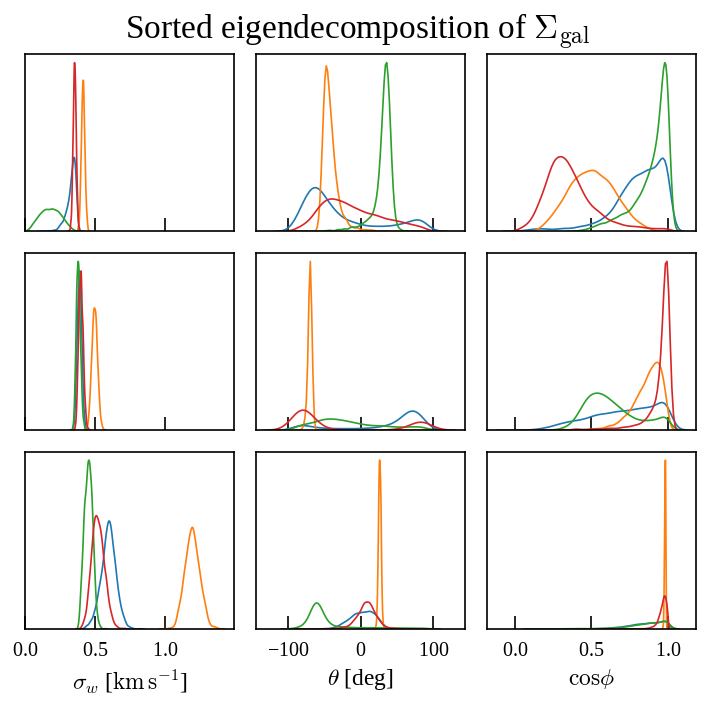

In [67]:
def cleanyticks(cax):
    cax.set_yticks([])


fig, axarr = plt.subplots(3, 3, figsize=(6, 6), sharex="col", dpi=120)


for k, azfit in azfit_dict.items():
    #     print(k)
    eig = kn.EigenvalueDecomposition(
        azfit.posterior["Sigma_gal"].stack(samples=["chain", "draw"]).T
    )
    #     with np.printoptions(formatter=dict(float=lambda x:'{:+8.3f}'.format(x))):
    #         print('eigval mean = {}'.format(np.sqrt(eig.w).mean(axis=0), precision=3))
    #         print('eigval std  = {}'.format(np.sqrt(eig.w).std(axis=0), precision=3))

    for irow, axrow in enumerate(axarr):

        sns.kdeplot(np.sqrt(eig.w[:, irow]), ax=axrow[0])
        sns.kdeplot(eig.theta[:, irow], ax=axrow[1])
        sns.kdeplot(eig.cosphi[:, irow], ax=axrow[2])
#         axrow[0].hist(np.sqrt(eig.w[:,irow]), density=True, bins=64, histtype="step", label=["0", "1", "2"])
#         axrow[1].hist(
#             eig.theta[:,irow], histtype="step", density=True, bins=32, #color=["C0", "C1", "C2"]
#         )
#         axrow[2].hist(
#             eig.cosphi[:,irow], histtype="step", density=True, bins=32, #color=["C0", "C1", "C2"]
#         )

axarr[2, 0].set_xlim(0)


fig.suptitle("Sorted eigendecomposition of $\Sigma_\mathrm{gal}$", size=20)
axarr[2, 0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
list(map(cleanyticks, axarr.ravel()))
axarr[2, 1].set_xlabel(r"$\theta$ [deg]")
axarr[2, 2].set_xlabel("$\cos\phi$")

ax[0].legend()
fig.tight_layout(rect=[0, 0.0, 1, 0.95])

C0 dr2
C1 all
C0 harpsRV
C1 harpsRVall


Text(0.5, 0.98, 'Velocity dispersion matrix in Galactic frame $\\Sigma_\\mathrm{gal}$')

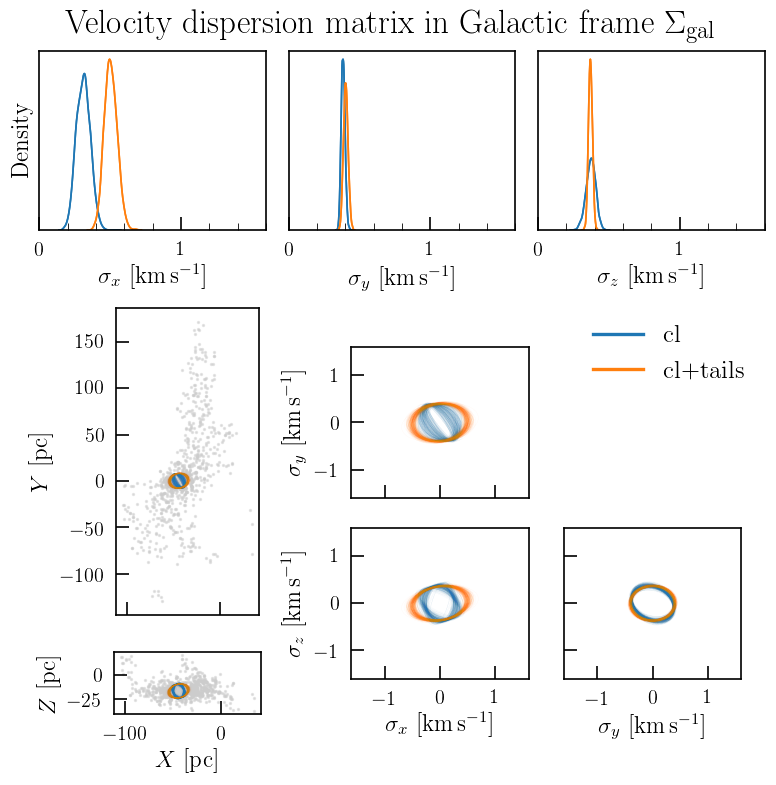

In [179]:
# Figure: posterior velocity disperion in Galactic frame
def cleanyticks(cax):
    cax.set_yticks([])


fig = plt.figure(figsize=(6.5, 6.5))
ax = fig.subplots(
    2, 2, gridspec_kw=dict(top=0.55, left=0.45, right=0.95), sharex=True, sharey=True
)
plt.delaxes(ax[0, 1])

axhist = fig.subplots(
    1, 3, gridspec_kw=dict(bottom=0.7, left=0.05, right=0.98, top=0.93, wspace=0.1)
)
for cax, axis in zip(axhist, ["x", "y", "z"]):
    cax.set_xlabel(r"$\sigma_{}$ [$\mathrm{{km}}\,\mathrm{{s}}^{{-1}}$]".format(axis))
    cleanyticks(cax)
axhist[0].set_ylabel("Density")

center_gal = np.array([-43.9034441, 0.17206561, -17.02724708])
scale = (
    20  # arbitrary multiplcation factor to make covar ellipse visible with positions
)
axOver = fig.subplots(
    2,
    1,
    gridspec_kw=dict(left=0.08, bottom=0.08, right=0.4, top=0.6, height_ratios=[5, 1]),
    sharex=True,
)
cdf = out_full.loc[out_full["Member_r19"] != "other"]
axOver[0].scatter(cdf["gx"], cdf["gy"], s=1, c="0.8", alpha=0.5)
axOver[1].scatter(cdf["gx"], cdf["gz"], s=1, c="0.8", alpha=0.5)
for cax in axOver:
    cax.set_aspect("equal")
axOver[1].set_xlabel("$X$ [pc]")
axOver[1].set_ylabel("$Z$ [pc]")
axOver[0].set_ylabel("$Y$ [pc]")

for (k, azfit), color in zip(azfit_dict.items(), ["C0", "C1", "C0", "C1"]):
    print(color, k)
    if k in ["dr2", "all"]:
        continue
    cov = azfit.posterior["Sigma_gal"].stack(i=["chain", "draw"]).values

    for i in np.random.randint(0, 4000, size=400):
        # x-y
        confidence_ellipse(
            cov[:, :, i], ax[0, 0], n_std=1, edgecolor=color, alpha=0.1, lw=0.1
        )
        confidence_ellipse(
            cov[:, :, i],
            axOver[0],
            center=center_gal[[0, 1]],
            n_std=scale,
            edgecolor=color,
            alpha=0.1,
            lw=0.1,
        )
        # x-z
        sel = np.meshgrid([0, 2], [0, 2], indexing="ij")
        confidence_ellipse(
            cov[sel[0], sel[1], i],
            ax[1, 0],
            n_std=1,
            edgecolor=color,
            alpha=0.1,
            lw=0.1,
        )
        confidence_ellipse(
            cov[sel[0], sel[1], i],
            axOver[1],
            center=center_gal[[0, 2]],
            n_std=scale,
            edgecolor=color,
            alpha=0.1,
            lw=0.1,
        )
        # y-z
        sel = np.meshgrid([1, 2], [1, 2], indexing="ij")
        confidence_ellipse(
            cov[sel[0], sel[1], i],
            ax[1, 1],
            n_std=1,
            edgecolor=color,
            alpha=0.1,
            lw=0.1,
        )

    for ii in range(3):
        axhist[ii].set_xlim(0, 1.6)
        axhist[ii].minorticks_on()
        axhist[ii].tick_params(axis="x", which="minor", length=4, width=0.5)
        sns.kdeplot(np.sqrt(cov[ii, ii]), ax=axhist[ii], color=color)
        sns.kdeplot(np.sqrt(cov[ii, ii]), ax=axhist[ii], color=color)

ax[0, 0].axis([-1.6, 1.6, -1.6, 1.6])
# make all ticklabels positive as there is no minus dispersion?

# legend
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color="C0", lw=2),
    Line2D([0], [0], color="C1", lw=2),
]
fig.legend(
    custom_lines, ["cl", "cl+tails"], loc=[0.75, 0.5], frameon=False, fontsize=15
)

# for i,j in zip(*np.triu_indices(3,k=1)): plt.delaxes(ax[i,j])
# for i,j in zip(*np.tril_indices(3, k=-1)):
#     print(i,j)
#     ax[i,j].set_xlim(-1.5,1.5)
#     ax[i,j].set_ylim(-1.5,1.5)
ax[1, 0].set_xlabel("$\sigma_x$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[0, 0].set_ylabel("$\sigma_y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 1].set_xlabel("$\sigma_y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 0].set_ylabel("$\sigma_z$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
fig.suptitle(
    "Velocity dispersion matrix in Galactic frame $\Sigma_\mathrm{gal}$", size=20
)
# savefig(fig, "Sigma_gal", rasterized=True)

In [162]:
coord.ICRS(*(b0 * u.pc), representation_type="cartesian").transform_to(
    coord.Galactic
).cartesian

<CartesianRepresentation (x, y, z) in pc
    (-43.9034441, 0.17206561, -17.02724708)>

Text(0.5, 0.98, 'Linear velocity field in Galactic frame')

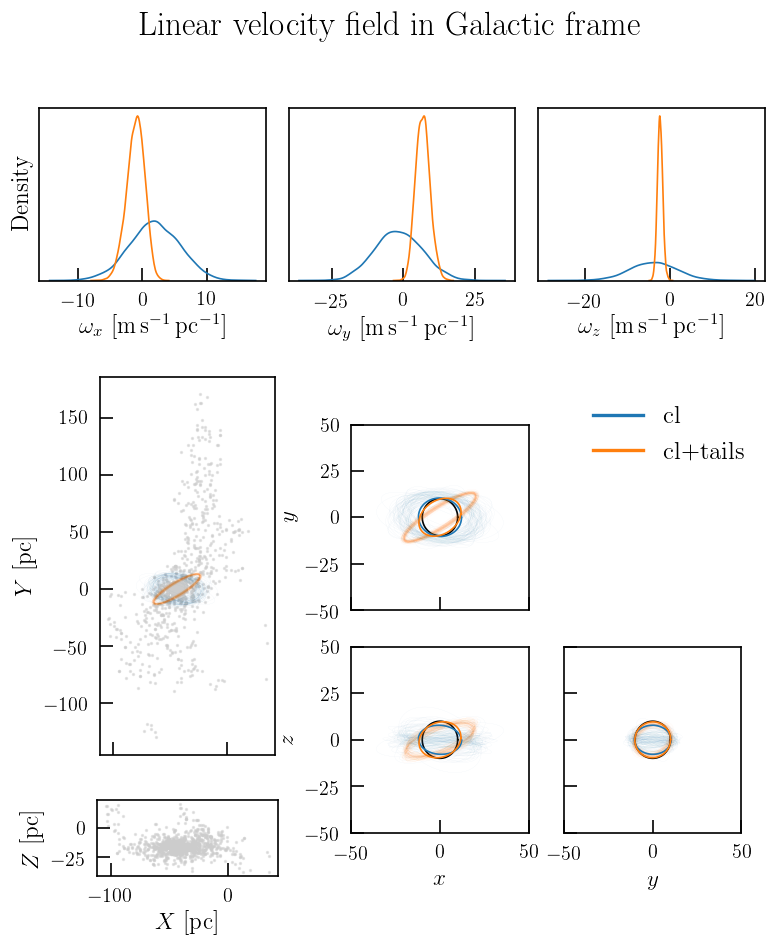

In [42]:
# Figure: posterior decomposed linear velocity field in Galactic frame
# v1. in style of velocity dispersion plot --- unfinished.
def cleanyticks(cax):
    cax.set_yticks([])


fig = plt.figure(figsize=(6.5, 8))
ax = fig.subplots(
    2, 2, gridspec_kw=dict(top=0.55, left=0.45, right=0.95), sharex=True, sharey=True
)
plt.delaxes(ax[0, 1])

axhist = fig.subplots(
    1, 3, gridspec_kw=dict(bottom=0.7, left=0.05, right=0.98, top=0.88, wspace=0.1)
)
for cax, axis in zip(axhist, ["x", "y", "z"]):
    cax.set_xlabel(
        r"$\omega_{}$ [$\mathrm{{m}}\,\mathrm{{s}}^{{-1}}\,\mathrm{{pc}}^{{-1}}$]".format(
            axis
        )
    )
    cleanyticks(cax)
axhist[0].set_ylabel("Density")

center_gal = np.array([-43.9034441, 0.17206561, -17.02724708])
scale = 1  # arbitrary multiplcation factor to make covar ellipse visible with positions
axOver = fig.subplots(
    2,
    1,
    gridspec_kw=dict(left=0.08, bottom=0.08, right=0.4, top=0.6, height_ratios=[5, 1]),
    sharex=True,
)
cdf = out_full.loc[out_full["Member_r19"] != "other"]
axOver[0].scatter(cdf["gx"], cdf["gy"], s=1, c="0.8", alpha=0.5)
axOver[1].scatter(cdf["gx"], cdf["gz"], s=1, c="0.8", alpha=0.5)
for cax in axOver:
    cax.set_aspect("equal")
axOver[1].set_xlabel("$X$ [pc]")
axOver[1].set_ylabel("$Z$ [pc]")
axOver[0].set_ylabel("$Y$ [pc]")

# Add the starting circle
plot_deformed_ellipse(np.eye(2) * 0, ax=ax[0, 0], lw=1, color="k")
plot_deformed_ellipse(np.eye(2) * 0, ax=ax[1, 0], lw=1, color="k")
plot_deformed_ellipse(np.eye(2) * 0, ax=ax[1, 1], lw=1, color="k", zorder=10)
for (k, stanfit), color in zip(fit_dict.items(), ["C0", "C1", "C0", "C1"]):
    if k not in ["dr2", "all"]:
        continue
    T_galactic = kn.rotate_T_to_galactic(stanfit["T_param"])
    T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1)))/2. * 0.0102
    #     v = T_sym**2*np.sign(T_sym) + np.repeat(np.eye(3)[None], 4000, 0)*400
    Tmean = T_sym.mean(axis=0)

    # Mean values
    plot_deformed_ellipse(Tmean[:2, :2], ax=ax[0, 0], lw=1, color=color, zorder=50)
    plot_deformed_ellipse(
        Tmean[np.ix_([0, 2], [0, 2])], ax=ax[1, 0], lw=1, color=color, zorder=50
    )
    plot_deformed_ellipse(Tmean[1:, 1:], ax=ax[1, 1], lw=1, color=color, zorder=50)
    for i in np.random.randint(0, 4000, size=100):
        # x-y
        plot_deformed_ellipse(
            T_sym[i, :2, :2] * 5, ax=ax[0, 0], lw=0.1, alpha=0.1, color=color
        )
        plot_deformed_ellipse(
            T_sym[i, :2, :2] * 5,
            ax=axOver[0],
            center=center_gal[:2],
            lw=0.1,
            alpha=0.1,
            color=color,
        )

        # x-z
        plot_deformed_ellipse(
            T_sym[i][np.ix_([0, 2], [0, 2])] * 5,
            ax=ax[1, 0],
            lw=0.1,
            alpha=0.1,
            color=color,
        )
        #         plot_deformed_ellipse(T_sym[i][np.ix_([0,2],[0,2])],
        #                               ax=axOver[1], lw=0.1, alpha=0.1, color=color)

        #         sel = np.meshgrid([0,2],[0,2],indexing='ij')
        #         confidence_ellipse(
        #             v[i,sel[0],sel[1]], ax[1,0],edgecolor=color,alpha=.1,lw=0.1,n_std=1)
        #         confidence_ellipse(cov[sel[0],sel[1],i], axOver[1],
        #                            center=center_gal[[0,2]],
        #                            n_std=scale, edgecolor=color,alpha=.1,lw=0.1)
        # y-z
        plot_deformed_ellipse(
            T_sym[i][np.ix_([1, 2], [1, 2])] * 5,
            ax=ax[1, 1],
            lw=0.1,
            alpha=0.1,
            color=color,
        )

    for ii, par in enumerate(["omegax_gal", "omegay_gal", "omegaz_gal"]):
        vals = azfit_dict[k].posterior[par].stack(i=["chain", "draw"]).values
        #         axhist[ii].set_xlim(0,1.6)
        #         axhist[ii].minorticks_on()
        #         axhist[ii].tick_params(axis='x',which='minor',length=4, width=.5)
        sns.kdeplot(vals, ax=axhist[ii], color=color)

axlim = 50
ax[0, 0].axis([-axlim, axlim, -axlim, axlim])
# # make all ticklabels positive as there is no minus dispersion?

# legend
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color="C0", lw=2),
    Line2D([0], [0], color="C1", lw=2),
]
fig.legend(
    custom_lines, ["cl", "cl+tails"], loc=[0.75, 0.5], frameon=False, fontsize=15
)
ax[1, 0].set_xlabel("$x$")
ax[0, 0].set_ylabel("$y$")
ax[1, 1].set_xlabel("$y$")
ax[1, 0].set_ylabel("$z$")
fig.suptitle("Linear velocity field in Galactic frame", size=20)
# savefig(fig, "decomposed_T_gal_harps", rasterized=True)


In [368]:
plt.rc("xtick", labelsize=12)

In [51]:
# to normalize dv/dx
(1 * u.m / u.s / u.pc).to(u.pc / (10 * u.Myr) / u.pc)  * 2

<Quantity 0.02045424 0.1 / Myr>

dr2 2.955045491522112 13.427982783513633
all 15.105481623451894 4.500314099863879


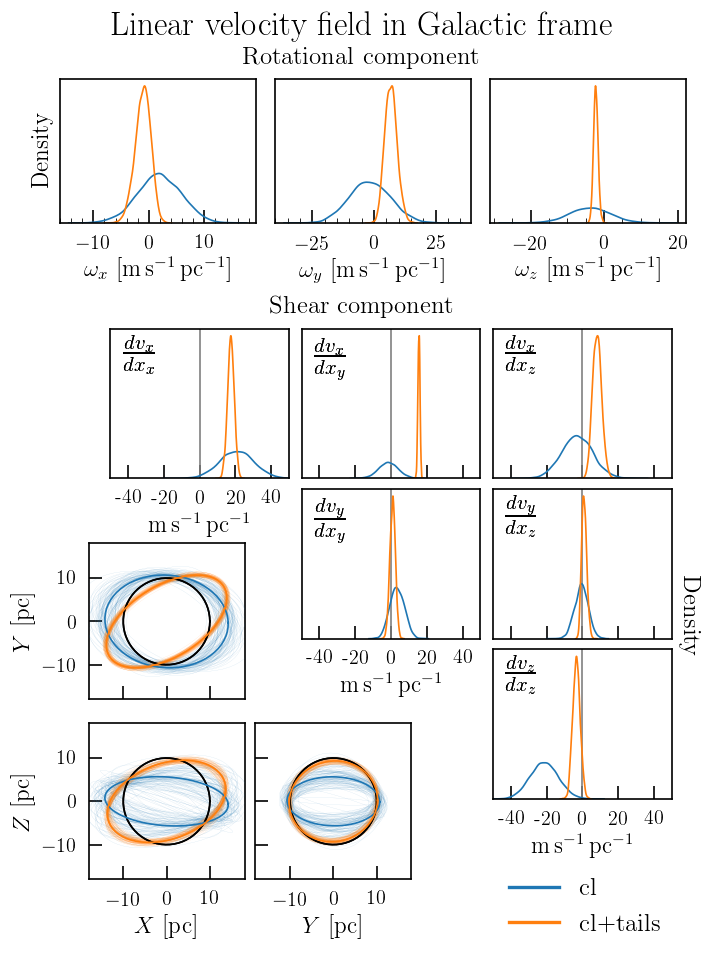

In [55]:
# Figure: posterior decomposed linear velocity field in Galactic frame
# v2 showing corner pdfs and corner deformed circles
def cleanyticks(cax):
    cax.set_yticks([])


fig = plt.figure(figsize=(6, 8))
ax = fig.subplots(
    3,
    3,
    gridspec_kw=dict(
        bottom=0.16, top=0.65, left=0.15, right=0.93, wspace=0.07, hspace=0.07
    ),
    sharex=True,
    sharey=False,
)
for i, j in zip(*np.tril_indices(3, k=-1)):
    ax[i, j].set_visible(False)
for cax in ax.ravel():
    cax.axvline(0, c="0.5", lw=1)
#     cax.minorticks_on()
#     cax.tick_params(axis='x',which='minor',length=3, width=.5)


fig.text(0.5, 0.66, "Shear component", size=15, ha="center", va="bottom")
axell = fig.subplots(
    3,
    3,
    gridspec_kw=dict(
        bottom=0.07, top=0.62, left=0.12, right=0.8, wspace=0.07, hspace=0.07
    ),
    sharex=True,
    sharey=True,
)
for i, j in zip(*np.triu_indices(3, k=0)):
    axell[i, j].set_visible(False)
axell[2, 0].set_xlabel("$X$ [pc]")
axell[2, 1].set_xlabel("$Y$ [pc]")
axell[1, 0].set_ylabel("$Y$ [pc]")
axell[2, 0].set_ylabel("$Z$ [pc]")

fig.text(0.5, 0.92, "Rotational component", size=15, ha="center", va="bottom")
axhist = fig.subplots(
    1, 3, gridspec_kw=dict(bottom=0.76, left=0.08, right=0.95, top=0.91, wspace=0.1)
)
for cax, axis in zip(axhist, ["x", "y", "z"]):
    cax.set_xlabel(
        r"$\omega_{}$ [$\mathrm{{m}}\,\mathrm{{s}}^{{-1}}\,\mathrm{{pc}}^{{-1}}$]".format(
            axis
        )
    )
    cleanyticks(cax)
axhist[0].set_ylabel("Density")

for (k, stanfit), color in zip(fit_dict.items(), ["C0", "C1", "C0", "C1"]):
    if k not in ["dr2", "all"]:
        continue
    T_galactic = kn.rotate_T_to_galactic(stanfit["T_param"])
    T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) * 0.5
    Tmean = T_sym.mean(axis=0)
    print(
        k,
        np.trace(T_sym, axis1=1, axis2=2).mean(),
        np.trace(T_sym, axis1=1, axis2=2).std(),
    )

    for i, j in zip(*np.triu_indices(3, k=0)):
        axis = ["x", "y", "z"]
        ax[i, j].text(
            0.07,
            0.93,
            r"$\frac{{dv_{}}}{{dx_{}}}$".format(axis[i], axis[j]),
            va="top",
            ha="left",
            transform=ax[i, j].transAxes,
            size=18,
        )
        sns.kdeplot(T_sym[:, i, j], ax=ax[i, j])

    for i, j in zip(*np.tril_indices(3, k=-1)):
        plot_deformed_ellipse(np.eye(2) * 0, ax=axell[i, j], lw=1, color="k", zorder=48)
        plot_deformed_ellipse(
            Tmean[np.ix_([j, i], [j, i])] * 0.0102 * 2,
            ax=axell[i, j],
            lw=1,
            color=color,
            zorder=50,
        )
        for isample in np.random.randint(0, 4000, size=100):
            plot_deformed_ellipse(
                T_sym[isample][np.ix_([j, i], [j, i])] * 0.0102 * 2,
                ax=axell[i, j],
                lw=0.1,
                alpha=0.3,
                color=color,
                zorder=30,
            )
    for ii, par in enumerate(["omegax_gal", "omegay_gal", "omegaz_gal"]):
        vals = azfit_dict[k].posterior[par].stack(i=["chain", "draw"]).values
        axhist[ii].minorticks_on()
        axhist[ii].tick_params(axis="x", which="minor", length=3, width=0.5)
        sns.kdeplot(vals, ax=axhist[ii], color=color)

axell[2, 0].axis([-18, 18, -18, 18])
for cax in axell.ravel():
    cax.set_aspect("equal")

ax[0, 0].set_xlim(-50, 50)
for i in range(3):
    plt.setp(ax[i, i].get_xticklabels(), visible=True)
    ax[i, i].set_xticks([-40, -20, 0, 20, 40])
    ax[i, i].set_xticklabels([-40, -20, 0, 20, 40])
    ax[i, i].xaxis.set_tick_params(which="both", labelbottom=True)
    ax[i, i].set_xlabel("$\mathrm{m}\,\mathrm{s}^{-1}\,\mathrm{pc}^{-1}$")
for cax in ax.ravel():
    cleanyticks(cax)
# fig.text(0.55, 0.05,
#         '$T_{ij}=dv_i/dx_j$'
#         ' [$\mathrm{m}\,\mathrm{s}^{-1}\,\mathrm{pc}^{-1}$]',
#          ha='center',va='top', size=15)
fig.text(0.94, 0.35, "Density", rotation=-90, va="center", ha="left", size=15)

# legend
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color="C0", lw=2),
    Line2D([0], [0], color="C1", lw=2),
]
fig.legend(
    custom_lines, ["cl", "cl+tails"], loc=[0.7, 0.01], frameon=False, fontsize=15
)


fig.suptitle("Linear velocity field in Galactic frame", size=20)

savefig(fig, "decomposed_T_gal_pdfs", rasterized=True)
# plt.close(fig)

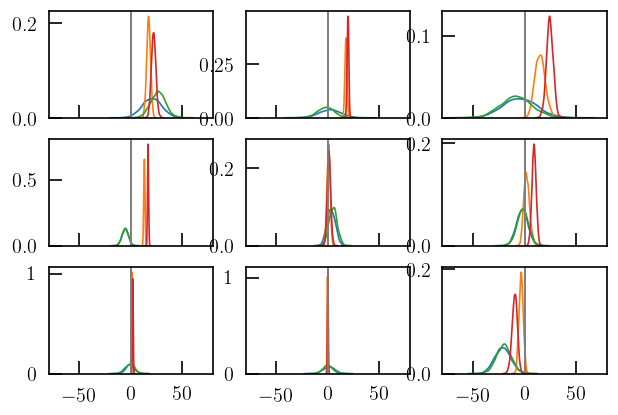

In [213]:
fig, ax = plt.subplots(3, 3, figsize=(6, 4), sharex=True, sharey=False, dpi=120)

for (k, stanfit), color in zip(fit_dict.items(), ["C0", "C1", "C3", "C4"]):
#     if k not in ["dr2", "all"]:
#         continue
    for i in range(3):
        for j in range(3):
            T_galactic = kn.rotate_T_to_galactic(stanfit["T_param"])
#             T_sym = T_galactic + np.transpose(T_galactic, (0, 2, 1))
            sns.kdeplot(T_galactic[:, i, j], ax=ax[i, j])
            ax[i, j].axvline(0, c="0.5", lw=1)
ax[0, 0].set_xlim(-80, 80);

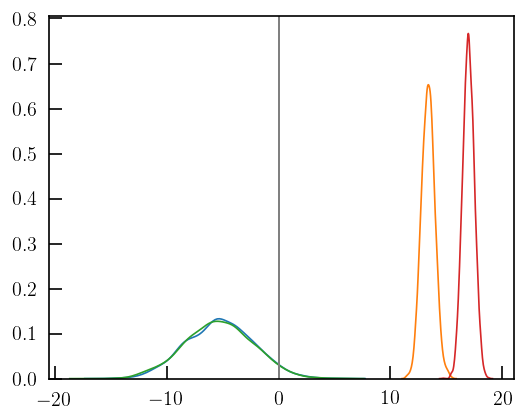

In [199]:
fig, ax = plt.subplots(1, 1)

for (k, stanfit), color in zip(fit_dict.items(), ["C0", "C1", "C3", "C4"]):
#     if k not in ["dr2", "all"]:
#         continue

    T_galactic = kn.rotate_T_to_galactic(stanfit["T_param"])
#             T_sym = T_galactic + np.transpose(T_galactic, (0, 2, 1))
    sns.kdeplot(T_galactic[:, 1, 0])
    ax.axvline(0, c="0.5", lw=1)
# ax[0, 0].set_xlim(-80, 80);

In [41]:
def plot_deformed_ellipse(dvdx, r=10, n=64, ax=None, vnorm=1, center=(0, 0), **kwargs):
    """
    Deform a circle according to the 2D strain rate tensor dvdx
    
    dvdx : array, (2,2)
        (i,j) is dv_i/d_vj
    r : float
        starting radius
    n : int
        number of linspace segments of the circle
    ax : Axes
        default will be current axes
    vnorm : float
        divide dvdx by this factor
    center : 2-tuple
        center of circle
    kwargs : dict
        they are passed to plt.plot
    """
    if ax is None:
        ax = plt.gca()
    dvdx = np.array(dvdx)
    assert dvdx.shape == (2, 2), "dvdx has wrong shape"

    theta = np.linspace(0, np.pi * 2, n)
    x, y = r * np.cos(theta), r * np.sin(theta)
    pos = np.vstack((x.ravel()[None], y.ravel()[None]))
    vel = np.einsum("ij,jn->in", dvdx, pos)

    xnew = vel[0] / vnorm + x
    ynew = vel[1] / vnorm + y

    #     ax.plot(x, y)
    ax.plot(xnew + center[0], ynew + center[1], **kwargs)
    return ax

## Membership

In [93]:
# add mean probmem to data
out_full['mean_pmem_all'] = fit_dict['all']['probmem'].mean(axis=0)
df['mean_pmem_dr2'] = fit_dict['dr2']['probmem'].mean(axis=0)
df['mean_pmem_harpsRV'] = fit_dict['harpsRV']['probmem'].mean(axis=0)

In [11]:
print('mean fmem =', fit_dict['dr2']['f_mem'].mean(), fit_dict['all']['f_mem'].mean())

print('N(mean Pmem < 0.5) = ',
      (df['mean_pmem_dr2']<0.5).sum(), (out_full['mean_pmem_all']<0.5).sum())

mean fmem = 0.9954897719364545 0.8500334749188017
N(mean Pmem < 0.5) =  1 201


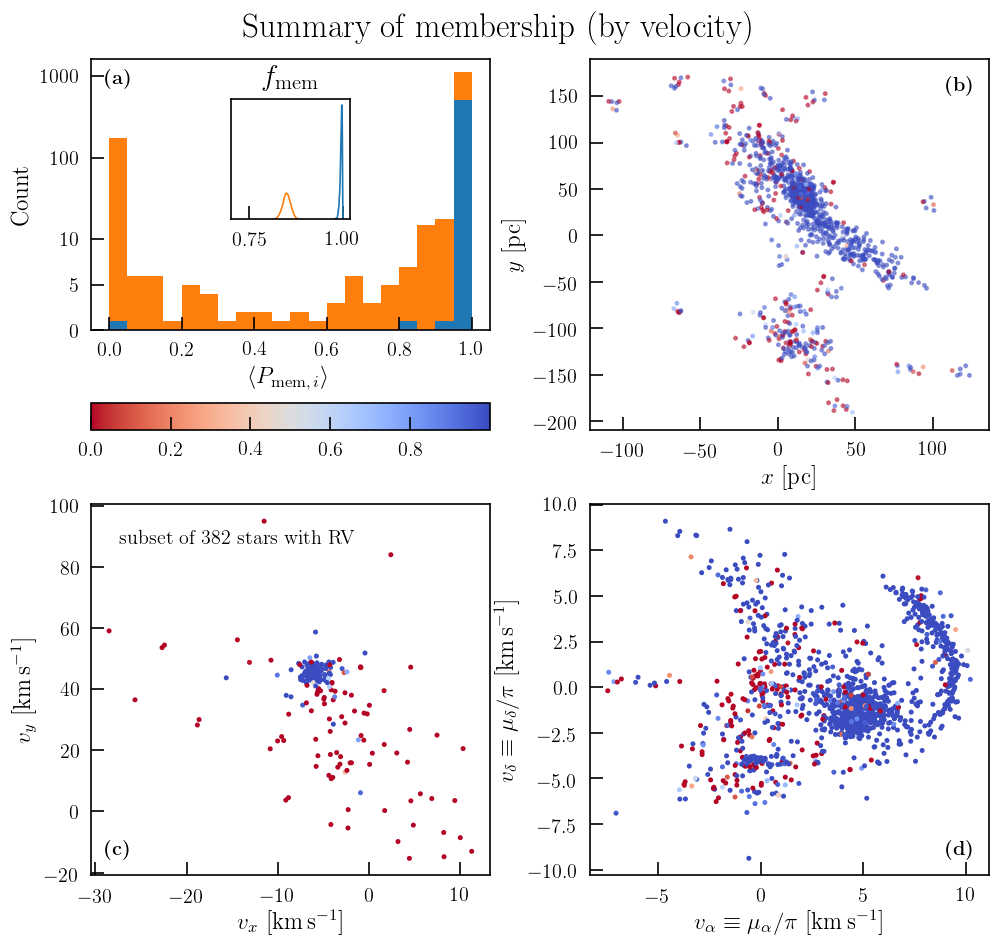

In [146]:
# Figure: summarize membership
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, ax = plt.subplots(
    2,
    2,
    figsize=(8.5, 8),
    gridspec_kw=dict(top=0.93, right=0.98, left=0.1, bottom=0.08, wspace=0.25),
)
fig.suptitle("Summary of membership (by velocity)", size=20)

# histogram of mean Pmem
bins = np.linspace(0, 1, 21)
ax[0, 0].hist(df["mean_pmem_dr2"], bins=bins)
ax[0, 0].hist(out_full["mean_pmem_all"], bins=bins, color="C1", zorder=-1)
ax[0, 0].set_yscale("symlog", linthreshy=10)
ax[0, 0].set_yticks([0, 5, 10, 100, 1000])
ax[0, 0].set_yticklabels([0, 5, 10, 100, 1000])
axins = inset_axes(
    ax[0, 0],
    width="30%",  # width = 30% of parent_bbox
    height=1.0,  # height : 1 inch
    loc=9,
    borderpad=2,
)
axins.set_title("$f_\mathrm{mem}$")
for k, f in fit_dict.items():
    if k in ["dr2", "all"]:
        sns.kdeplot(f["f_mem"], ax=axins)
axins.set_xlim(0.7, 1.02)
axins.set_yticks([])
ax[0, 0].set_xlabel(r"$\langle P_{\mathrm{mem},\,i}\rangle$")
ax[0, 0].set_ylabel("Count")

# ICRS x-y space
# hacking colorbar
paths = ax[0, 1].scatter(
    out_full["x"],
    out_full["y"],
    c=out_full["mean_pmem_all"],
    s=4,
    cmap="coolwarm_r",
    visible=False,
)
_ = ax[0, 1].scatter(
    out_full["x"],
    out_full["y"],
    c=out_full["mean_pmem_all"],
    s=4,
    cmap="coolwarm_r",
    alpha=0.5,
)
# Attach colorbar below histogram for better arrangement
ax1_divider = make_axes_locatable(ax[0, 0])
cax1 = ax1_divider.append_axes("bottom", size="10%", pad="27%")
cb = plt.colorbar(paths, cax=cax1, orientation="horizontal")

ax[0, 1].set_xlabel("$x$ [pc]")
ax[0, 1].set_ylabel("$y$ [pc]")


ax[1, 0].scatter(
    out_full["vx"], out_full["vy"], c=out_full["mean_pmem_all"], s=4, cmap="coolwarm_r"
)
ax[1, 0].set_xlabel("$v_x$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 0].set_ylabel("$v_y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 0].text(
    0.07,
    0.93,
    "subset of {} stars with RV".format(out_full["radial_velocity"].notnull().sum()),
    transform=ax[1, 0].transAxes,
    ha="left",
    va="top",
)

ax[1, 1].scatter(
    #     out_full["parallax"],
    #     out_full["vy"],
    out_full["pmra"] / out_full["parallax"],
    out_full["pmdec"] / out_full["parallax"],
    c=out_full["mean_pmem_all"],
    s=4,
    cmap="coolwarm_r",
)
# ax[1, 1].set_ylim(30, 65)
ax[1, 1].set_xlabel(r"$v_\alpha\equiv\mu_\alpha/\pi$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1, 1].set_ylabel(r"$v_\delta\equiv\mu_\delta/\pi$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")

# label panels
for cax, (x, y, t) in zip(
    ax.ravel(),
    [
        (0.07, 0.93, r"\bf(a)"),
        (0.93, 0.93, r"\bf(b)"),
        (0.07, 0.07, r"\bf(c)"),
        (0.93, 0.07, r"\bf(d)"),
    ],
):
    cax.text(x, y, t, transform=cax.transAxes, va="center", ha="center")
savefig(fig, "membership", rasterized=True)

## DRV

In [111]:
drv.mean(axis=0)[52]

-0.3741769141872126

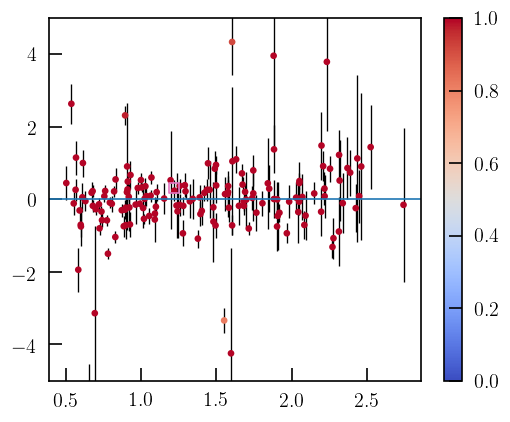

In [123]:
irv = fit_dict["dr2"].data["irv"]
drv = df["radial_velocity"].values[None, irv] - fit_dict["dr2"]["rv_model"]
patches = plt.scatter(
    df["bp_rp"][irv],
    drv.mean(axis=0),
    c=df.loc[irv, "mean_pmem_dr2"],
    cmap="coolwarm",
    s=9,vmin=0,vmax=1
)
_ = plt.scatter(
    df["bp_rp"][496],
    drv.mean(axis=0)[52],marker='s',facecolors='',edgecolors='C6'
)
plt.errorbar(
    df["bp_rp"][irv], drv.mean(axis=0), yerr=df.loc[irv, "radial_velocity_error"], ls="",
    c='k',zorder=-1, elinewidth=.8
)
plt.ylim(-5,5);
plt.colorbar(patches);
plt.axhline(0);

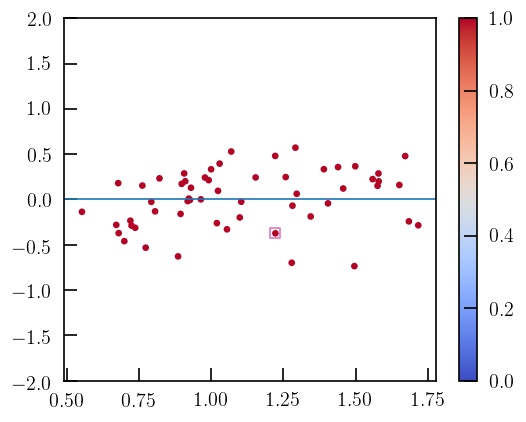

In [119]:
irv = fit_dict["harpsRV"].data["irv"]
drv = df["RV_HARPS_leao"].values[None, irv] - fit_dict["harpsRV"]["rv_model"]
patches = plt.scatter(
    df["bp_rp"][irv],
    drv.mean(axis=0),
    c=df.loc[irv, "mean_pmem_harpsRV"],
    cmap="coolwarm",
    s=9,vmin=0,vmax=1
)
_ = plt.scatter(
    df["bp_rp"][496],
    drv.mean(axis=0)[52],marker='s',facecolors='',edgecolors='C6'
)
plt.errorbar(
    df["bp_rp"][irv], drv.mean(axis=0), yerr=df.loc[irv, "eRV_HARPS_leao"], ls="",
    c='k',zorder=-1, elinewidth=.8
)
plt.ylim(-2,2);
plt.colorbar(patches);
plt.axhline(0)

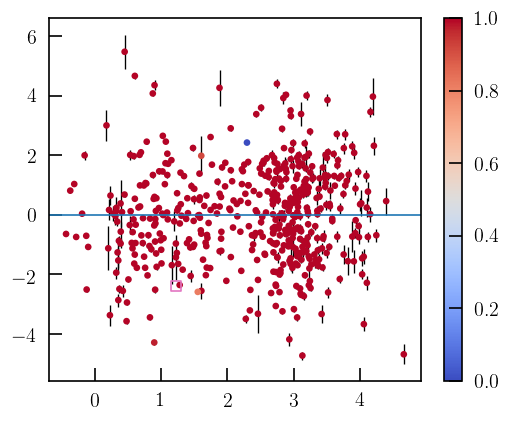

In [133]:

drv = df["pmdec"].values[None] - fit_dict["dr2"]["a_model"][:,:,2]
patches = plt.scatter(
    df["bp_rp"],
    drv.mean(axis=0),
    c=df["mean_pmem_dr2"],
    cmap="coolwarm",
    s=9,vmin=0,vmax=1
)
_ = plt.scatter(
    df["bp_rp"][496],
    drv.mean(axis=0)[52],marker='s',facecolors='',edgecolors='C6'
)
plt.errorbar(
    df["bp_rp"], drv.mean(axis=0), yerr=df["pmdec_error"], ls="",
    c='k',zorder=-1, elinewidth=.8
)
# plt.ylim(-2,2);
plt.colorbar(patches);
plt.axhline(0)

In [106]:
np.where(irv==496)

(array([52]),)

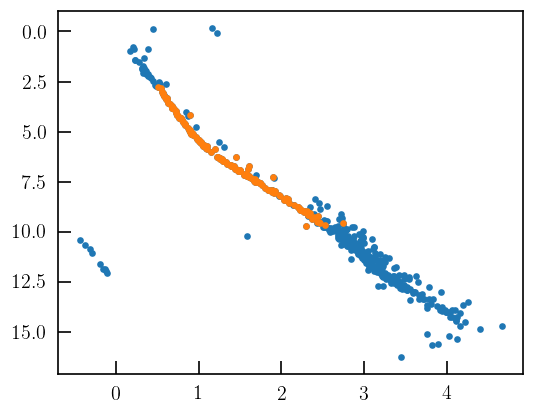

In [124]:
fig, ax = plt.subplots()
irv = fit_dict["dr2"].data["irv"]
ax.scatter(df['bp_rp'],df['phot_g_mean_mag']+df.g.distmod,s=9);
ax.scatter(df.loc[irv,'bp_rp'],df.loc[irv,'phot_g_mean_mag']+df.loc[irv].g.distmod,s=9);
# ax.scatter(df.loc[irv,'bp_rp'],df.loc[irv,'phot_g_mean_mag']+df.loc[irv].g.distmod,s=9);
ax.invert_yaxis()

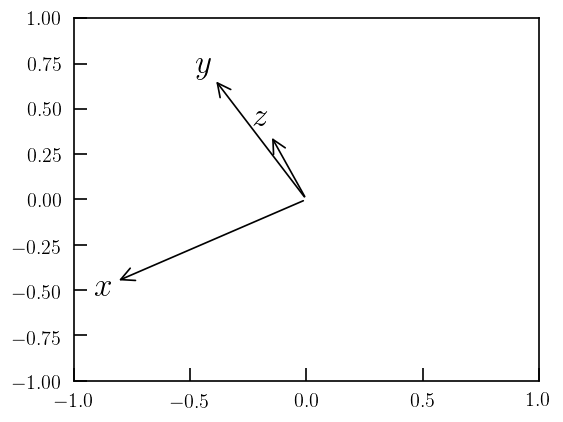

In [8]:

# annotate Galactic frame projected onto ICRS
unitv_gal_in_icrs = coord.Galactic(
    [1, 0, 0], [0, 1, 0], [0, 0, 1], representation_type="cartesian"
).transform_to(coord.ICRS).cartesian

xaxis, yaxis = 'y','z'
for i,axis in enumerate(['x','y','z']):
#     plt.plot([0,unitv_gal_in_icrs[i].x],[0,unitv_gal_in_icrs[i].y],label=axis,)
    dxdy = [getattr(unitv_gal_in_icrs[i], xaxis), getattr(unitv_gal_in_icrs[i], yaxis)]
    # using arrow and text
#     plt.arrow(*[0,0], *dxdy,
#               color='k',lw=1,)
#     plt.text(*dxdy, axis,)
    # using annotate
    ann = plt.annotate('${}$'.format(axis),
                      xy=[0,0], xycoords='data',
                      xytext=dxdy, textcoords='data',
                      size=20, va="center", ha="center",
#                       bbox=dict(boxstyle="round4", fc="w"),
                      arrowprops=dict(arrowstyle="<-"),
                      )
plt.axis([-1,1,-1,1]);

<ErrorbarContainer object of 3 artists>

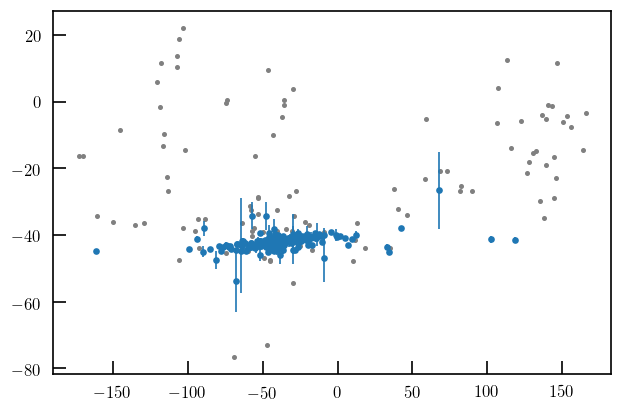

In [227]:
plt.figure(dpi=120)
plt.scatter(out_full["gx"], out_full["gvx"], s=4, c="0.5")
plt.scatter(out_full["gx"][mem], out_full["gvx"][mem], s=9)
plt.errorbar(
    out_full["gx"][mem],
    out_full["gvx"][mem],
    out_full["radial_velocity_error"][mem],
    ls="",
)

## checking RUWE

In [153]:
from wsdb import wsdb

# wsdb.upload_df(out_full[["source_id"]], "hyfull")

ruwe = wsdb.query(
    """select ruwe.source_id, ruwe
from semyeong_oh.hyfull as d left join gaia_dr2.ruwe on d.source_id=gaia_dr2.ruwe.source_id;"""
)

out_full_ruwe = out_full.merge(ruwe, on="source_id")

In [ ]:
out_full.columns

In [169]:
bad_astrometry = (out_full_ruwe['ruwe']>1.4)# | (out_full_ruwe['duplicated_source'])
print(bad_astrometry.sum())

127


In [162]:
out_full_ruwe.groupby(
    by=[out_full_ruwe["ruwe"] > 1.4, out_full_ruwe["duplicated_source"]]
)["source_id"].count()

ruwe   duplicated_source
False  False                1114
       True                  148
True   False                 117
       True                   10
Name: source_id, dtype: int64

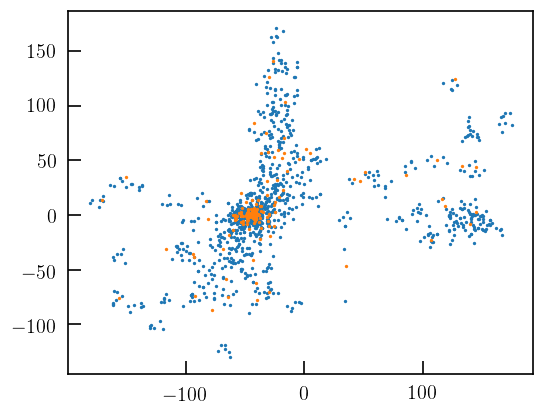

In [174]:
fig, ax = plt.subplots()
for l, g in out_full_ruwe.groupby('duplicated_source'):
    ax.scatter(g['gx'],g['gy'],s=1);

In [156]:
grp_by_pmem = out_full_ruwe.groupby(pd.cut(out_full_ruwe['mean_pmem_all'], [0., 0.5, 0.9, 1]))
grp_by_pmem[['duplicated_source']].describe()

duplicated_source                    
                          count unique    top  freq
mean_pmem_all                                      
(0.0, 0.5]                  199      2  False   183
(0.5, 0.9]                   42      2  False    40
(0.9, 1.0]                 1146      2  False  1006

In [414]:
out_full_ruwe["ruwe"].describe()

count    1389.000000
mean        1.235694
std         0.842037
min         0.725516
25%         1.008400
50%         1.089720
75%         1.203340
max        16.823600
Name: ruwe, dtype: float64

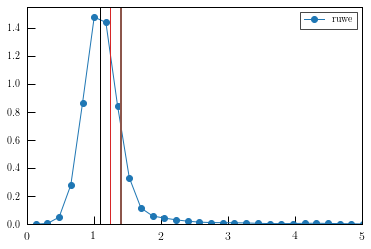

In [428]:
sns.kdeplot(out_full_ruwe["ruwe"], marker="o")
plt.xlim(0, 5)
plt.axvline(out_full_ruwe["ruwe"].median(), c="k")
plt.axvline(out_full_ruwe["ruwe"].mean(), c="C3")
plt.axvline(1.4, c="C5", lw=2);